# Creating a Databunch for Basecalling

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.basics import *

import jkbc.utils.experimentation as e
import jkbc.utils.files as f
import jkbc.utils.loss as l
import jkbc.utils.postprocessing as pop
import jkbc.utils.preprocessing as prep

## Constants

### Data

In [6]:
BLANK_ID       = pop.BLANK_ID
ALPHABET       = pop.ALPHABET # {0: '-', 1: 'A', 2: 'B'}
ALPHABET_VAL   = list(ALPHABET.values())
ALPHABET_STR   = ''.join(ALPHABET_VAL)
ALPHABET_SIZE  = len(ALPHABET_VAL)
WINDOW_SIZE    = 300
STRIDE         = 300
DIMENSIONS_OUT = 70

### Model

In [7]:
DIMENSIONS_PREDICTION_OUT = 1     # DIMENSIONS_OUT*2-1
DROP_LAST    = False # SET TO TRUE IF IT FAILS ON LAST BATCH
## Add Model specific variables here

### Train/Predict

In [8]:
BS = 1024  # batch size
DEVICE = torch.device("cuda:0") #torch.device("cpu")
MODEL_NAME = None # TODO

### Data path

In [9]:
BASE_DIR = Path("..")
PATH_DATA = 'data/feather-files'
DATA_SET = f'Range0-2000-FixLabelLen{DIMENSIONS_OUT}'
FEATHER_FOLDER = BASE_DIR/PATH_DATA/DATA_SET

## Load data

In [12]:
# Read data from feather
data = f.read_data_from_feather_file(FEATHER_FOLDER)

# Convert to databunch
train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=DROP_LAST)
del data
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)
del train_dl
del valid_dl

## Model

In [19]:
loss_func = l.ctc_loss(DIMENSIONS_PREDICTION_OUT, BS, ALPHABET_SIZE)

## TODO: MAKE MODEL

In [20]:
model = nn.Sequential(
    nn.Linear(WINDOW_SIZE, ALPHABET_SIZE)
    ,nn.LogSoftmax(dim=2) 
).to(device=DEVICE)

In [21]:
learner = Learner(databunch, model, loss_func=loss_func, path=BASE_DIR)

In [22]:
try:
    learner = learner.load(MODEL_NAME)
    print('Model weights loaded')
except:
    print('No model weights available')

No model weights available


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-08


/user/student.aau.dk/jfraus14/.conda/envs/jkbc/lib/python3.7/site-packages/numpy/lib/function_base.py:1057: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/user/student.aau.dk/jfraus14/.conda/envs/jkbc/lib/python3.7/site-packages/numpy/lib/function_base.py:1078: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/user/student.aau.dk/jfraus14/.conda/envs/jkbc/lib/python3.7/site-packages/numpy/lib/function_base.py:1085: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


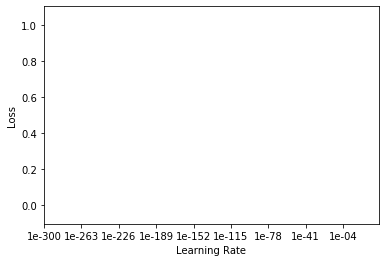

In [23]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(500, max_lr=learner.recorder.min_grad_lr)

In [ ]:
learner.save(MODEL_NAME)

In [26]:
x, (y, _) = databunch.one_batch()
x_device = x.to(device=DEVICE)
y_pred = model(x_device).detach().cpu().numpy()

In [ ]:
r = range(min(5, PRED_OUT_DIM), min(PRED_OUT_DIM+1, 50)) #Range can't contain values larger than PRED_OUT_DIM

for index in [0, BS-1]:
    actual = pop.convert_idx_to_base_sequence(y[index], ALPHABET_VAL)
    prediction = y_pred[index]
    for pred, beam, error in e.get_stats(prediction, actual, ALPHABET_STR, r):
        print(pred, beam, error.error)
    print('')

In [28]:
# Run assemble only if data is not fetched from featherfile
# TODO: Assembled should not be on a batch, but instead on a complete signal
if STRIDE != WINDOW_SIZE:
    decoded = pop.decode(y_pred, ALPHABET_STR, beam_size=15)
    assembled = pop.assemble(decoded, WINDOW_SIZE, STRIDE, ALPHABET)
    print('Assembled:', assembled)